In [9]:
import optuna
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.optimizers import Adam, SGD
from optuna.samplers import TPESampler, GridSampler

In [10]:
#test.csv,train.csvを取得
X_train_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/X_train.csv"
y_train_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/y_train.csv"
X_test_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/X_test.csv"
y_test_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/y_test.csv"
df_train_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/df_train.csv"
df_test_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/df_test.csv"

# Numpy配列としてよみこむ
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path)
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)

# dfはDataFrameとしてよみこむ
df_train = pd.read_csv(df_train_path)
df_test = pd.read_csv(df_test_path)

In [11]:
rmses = []
folds = 10
print(X_train.shape)

def create_model(trial):
    inputs = Input(shape=(25,))

    # 入力層を作成
    x = Dense(25, activation='relu')(inputs)

    # 中間層の作成
    # ハイパーパラメータの最適化
    n_layers = trial.suggest_int('n_layers', 1, 5)
    units = trial.suggest_int('n_units', 8, 256, step=8)
    for i in range(n_layers):
        x = Dense(units=units, activation='relu')(x)
        
    x = Flatten()(x)

    # 出力層の作成
    predictions = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=predictions)

    # オプティマイザと学習率の最適化
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'RMSProp'])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)

    if optimizer_name == 'adam':
        optimizer = Adam()
    if optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=lr)
    else:
        optimizer = 'RMSProp'

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

def objective(trial):
    # モデルの作成
    model = create_model(trial)

    # batch_size範囲を指定
    batch_size = trial.suggest_int('batch_size', 16, 256, step=16)

    # KFold のオブジェクトを作成
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)

    
    for train_index, valid_index in kf.split(X_train):
        X_train_subset = X_train.loc[train_index].values
        y_train_subset = y_train.loc[train_index].values
        X_valid_subset = X_train.loc[valid_index].values
        y_valid_subset = y_train.loc[valid_index].values

        # トレーニング
        model.fit(
            X_train_subset, y_train_subset, 
            batch_size=batch_size,
            epochs=100, 
            verbose=0
        )

        # 予測
        y_pred = model.predict(X_valid_subset)

        # NaN が含まれているか確認
        if np.isnan(y_pred).any():
            print(" NaN が含まれているので関数から抜け出します。")
            return 

        # RMSEを算出
        temp_rmse_valid = np.sqrt(mean_squared_error(y_valid_subset, y_pred))

        # RMSEをリストにappend
        rmses.append(temp_rmse_valid)

        # CVのRMSEの平均値を目的関数として返す
        return np.mean(rmses)
    

# ------------------------------------
# # ベイズ最適化
sampler = TPESampler()
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=100)

print('Number of finalized trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# 最適なパラメータの表示

for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

[I 2023-12-13 14:18:49,814] A new study created in memory with name: no-name-cce57227-4c69-43e1-959c-05c57586742c


(403, 25)


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:18:51,609] Trial 0 finished with value: 24.731430198062213 and parameters: {'n_layers': 5, 'n_units': 248, 'optimizer': 'adam', 'lr': 0.001179161265486978, 'batch_size': 64}. Best is trial 0 with value: 24.731430198062213.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[W 2023-12-13 14:18:52,667] Trial 1 failed with parameters: {'n_layers': 4, 'n_units': 80, 'optimizer': 'sgd', 'lr': 0.008870167779489305, 'batch_size': 80} because of the following error: The value None could not be cast to float..
[W 2023-12-13 14:18:52,667] Trial 1 failed with value None.


 NaN が含まれているので関数から抜け出します。


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:18:53,924] Trial 2 finished with value: 19.582897617022862 and parameters: {'n_layers': 2, 'n_units': 240, 'optimizer': 'sgd', 'lr': 0.0002211141338539954, 'batch_size': 48}. Best is trial 2 with value: 19.582897617022862.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:18:55,364] Trial 3 finished with value: 18.727097649658248 and parameters: {'n_layers': 5, 'n_units': 224, 'optimizer': 'sgd', 'lr': 1.0825193357745199e-05, 'batch_size': 80}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:18:56,582] Trial 4 finished with value: 19.679038085968518 and parameters: {'n_layers': 4, 'n_units': 104, 'optimizer': 'RMSProp', 'lr': 2.010278671153781e-05, 'batch_size': 192}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:18:57,693] Trial 5 finished with value: 19.73390765347498 and parameters: {'n_layers': 5, 'n_units': 232, 'optimizer': 'sgd', 'lr': 1.2359013422737527e-05, 'batch_size': 224}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:18:58,627] Trial 6 finished with value: 19.626961860758474 and parameters: {'n_layers': 3, 'n_units': 160, 'optimizer': 'RMSProp', 'lr': 1.450863495194058e-05, 'batch_size': 240}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:18:59,777] Trial 7 finished with value: 20.200693666380396 and parameters: {'n_layers': 5, 'n_units': 208, 'optimizer': 'RMSProp', 'lr': 0.002297283722034546, 'batch_size': 240}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[W 2023-12-13 14:19:00,560] Trial 8 failed with parameters: {'n_layers': 1, 'n_units': 168, 'optimizer': 'sgd', 'lr': 0.00429110997684795, 'batch_size': 96} because of the following error: The value None could not be cast to float..
[W 2023-12-13 14:19:00,561] Trial 8 failed with value None.


 NaN が含まれているので関数から抜け出します。


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:01,465] Trial 9 finished with value: 19.82476650327793 and parameters: {'n_layers': 3, 'n_units': 56, 'optimizer': 'RMSProp', 'lr': 0.048519411373721, 'batch_size': 240}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:03,476] Trial 10 finished with value: 19.458336826469267 and parameters: {'n_layers': 1, 'n_units': 216, 'optimizer': 'RMSProp', 'lr': 9.61661708199565e-05, 'batch_size': 16}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:04,791] Trial 11 finished with value: 19.82208853552215 and parameters: {'n_layers': 4, 'n_units': 216, 'optimizer': 'adam', 'lr': 7.200857815715954e-05, 'batch_size': 96}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[W 2023-12-13 14:19:06,048] Trial 12 failed with parameters: {'n_layers': 4, 'n_units': 152, 'optimizer': 'sgd', 'lr': 0.000304316954940099, 'batch_size': 144} because of the following error: The value None could not be cast to float..
[W 2023-12-13 14:19:06,048] Trial 12 failed with value None.


 NaN が含まれているので関数から抜け出します。


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:06,991] Trial 13 finished with value: 21.401773349440827 and parameters: {'n_layers': 4, 'n_units': 8, 'optimizer': 'sgd', 'lr': 0.00037680021591177397, 'batch_size': 144}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:08,850] Trial 14 finished with value: 20.852598174392067 and parameters: {'n_layers': 1, 'n_units': 184, 'optimizer': 'sgd', 'lr': 6.272465938166286e-05, 'batch_size': 16}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:10,784] Trial 15 finished with value: 20.44377369059889 and parameters: {'n_layers': 1, 'n_units': 136, 'optimizer': 'RMSProp', 'lr': 6.358212535014636e-05, 'batch_size': 16}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:11,684] Trial 16 finished with value: 20.20305254896096 and parameters: {'n_layers': 2, 'n_units': 176, 'optimizer': 'sgd', 'lr': 3.870446047292562e-05, 'batch_size': 112}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:12,774] Trial 17 finished with value: 19.948287737977036 and parameters: {'n_layers': 2, 'n_units': 96, 'optimizer': 'adam', 'lr': 1.1719357051082852e-05, 'batch_size': 64}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:13,585] Trial 18 finished with value: 19.956785236099364 and parameters: {'n_layers': 1, 'n_units': 256, 'optimizer': 'RMSProp', 'lr': 0.00016788891313399343, 'batch_size': 144}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:14,591] Trial 19 finished with value: 19.736997572957613 and parameters: {'n_layers': 3, 'n_units': 200, 'optimizer': 'sgd', 'lr': 3.2655236408222986e-05, 'batch_size': 96}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:16,147] Trial 20 finished with value: 19.482835996876904 and parameters: {'n_layers': 4, 'n_units': 152, 'optimizer': 'RMSProp', 'lr': 0.00014054739921711876, 'batch_size': 48}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:18,240] Trial 21 finished with value: 19.178516997956176 and parameters: {'n_layers': 2, 'n_units': 120, 'optimizer': 'sgd', 'lr': 3.234055087526093e-05, 'batch_size': 16}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:19,360] Trial 22 finished with value: 19.003306833665246 and parameters: {'n_layers': 2, 'n_units': 96, 'optimizer': 'sgd', 'lr': 2.9950157233443956e-05, 'batch_size': 112}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:20,246] Trial 23 finished with value: 18.93705726067364 and parameters: {'n_layers': 3, 'n_units': 64, 'optimizer': 'sgd', 'lr': 1.380698949164638e-05, 'batch_size': 160}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:21,133] Trial 24 finished with value: 18.9468572531487 and parameters: {'n_layers': 3, 'n_units': 64, 'optimizer': 'sgd', 'lr': 1.0277047445764994e-05, 'batch_size': 176}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:22,017] Trial 25 finished with value: 18.951277904832274 and parameters: {'n_layers': 3, 'n_units': 48, 'optimizer': 'sgd', 'lr': 1.3034465218760668e-05, 'batch_size': 176}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:22,905] Trial 26 finished with value: 18.93102596691379 and parameters: {'n_layers': 3, 'n_units': 64, 'optimizer': 'sgd', 'lr': 1.1638613294880754e-05, 'batch_size': 176}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:23,751] Trial 27 finished with value: 18.932601633474626 and parameters: {'n_layers': 4, 'n_units': 24, 'optimizer': 'sgd', 'lr': 2.5843748877355784e-05, 'batch_size': 192}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:24,620] Trial 28 finished with value: 20.281395913124154 and parameters: {'n_layers': 5, 'n_units': 8, 'optimizer': 'sgd', 'lr': 3.13992371326961e-05, 'batch_size': 192}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:25,483] Trial 29 finished with value: 20.212906821201457 and parameters: {'n_layers': 4, 'n_units': 40, 'optimizer': 'sgd', 'lr': 2.2801860389920684e-05, 'batch_size': 208}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:26,508] Trial 30 finished with value: 20.19075093587776 and parameters: {'n_layers': 5, 'n_units': 24, 'optimizer': 'adam', 'lr': 4.471712920664282e-05, 'batch_size': 208}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:27,743] Trial 31 finished with value: 20.13116782047141 and parameters: {'n_layers': 4, 'n_units': 72, 'optimizer': 'sgd', 'lr': 2.3328229251650393e-05, 'batch_size': 128}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:28,951] Trial 32 finished with value: 20.00084459564517 and parameters: {'n_layers': 5, 'n_units': 80, 'optimizer': 'adam', 'lr': 1.0198369245031264e-05, 'batch_size': 160}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:29,821] Trial 33 finished with value: 20.661538719974416 and parameters: {'n_layers': 4, 'n_units': 32, 'optimizer': 'sgd', 'lr': 5.601668081958218e-05, 'batch_size': 256}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:30,653] Trial 34 finished with value: 20.551449346010678 and parameters: {'n_layers': 3, 'n_units': 80, 'optimizer': 'sgd', 'lr': 1.9310008345479093e-05, 'batch_size': 160}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:31,475] Trial 35 finished with value: 20.473972602867857 and parameters: {'n_layers': 3, 'n_units': 24, 'optimizer': 'sgd', 'lr': 1.9914192689795082e-05, 'batch_size': 176}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:32,412] Trial 36 finished with value: 20.399363263966304 and parameters: {'n_layers': 4, 'n_units': 120, 'optimizer': 'sgd', 'lr': 1.7512211300485915e-05, 'batch_size': 160}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:33,173] Trial 37 finished with value: 20.590665724095246 and parameters: {'n_layers': 3, 'n_units': 48, 'optimizer': 'sgd', 'lr': 0.00010273542656630596, 'batch_size': 192}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:34,151] Trial 38 finished with value: 20.55742227635775 and parameters: {'n_layers': 5, 'n_units': 112, 'optimizer': 'sgd', 'lr': 1.1319818786288849e-05, 'batch_size': 208}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:35,024] Trial 39 finished with value: 20.46179976691537 and parameters: {'n_layers': 3, 'n_units': 88, 'optimizer': 'sgd', 'lr': 2.1081318844526072e-05, 'batch_size': 128}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[W 2023-12-13 14:19:36,231] Trial 40 failed with parameters: {'n_layers': 4, 'n_units': 64, 'optimizer': 'sgd', 'lr': 0.00030549676485012225, 'batch_size': 64} because of the following error: The value None could not be cast to float..
[W 2023-12-13 14:19:36,231] Trial 40 failed with value None.


 NaN が含まれているので関数から抜け出します。


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[W 2023-12-13 14:19:37,853] Trial 41 failed with parameters: {'n_layers': 4, 'n_units': 240, 'optimizer': 'sgd', 'lr': 0.00026786000481443523, 'batch_size': 80} because of the following error: The value None could not be cast to float..
[W 2023-12-13 14:19:37,853] Trial 41 failed with value None.


 NaN が含まれているので関数から抜け出します。


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:38,987] Trial 42 finished with value: 20.32244352068178 and parameters: {'n_layers': 4, 'n_units': 64, 'optimizer': 'sgd', 'lr': 4.148974837882938e-05, 'batch_size': 80}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[W 2023-12-13 14:19:40,035] Trial 43 failed with parameters: {'n_layers': 5, 'n_units': 144, 'optimizer': 'sgd', 'lr': 0.00025587673351456163, 'batch_size': 224} because of the following error: The value None could not be cast to float..
[W 2023-12-13 14:19:40,035] Trial 43 failed with value None.


 NaN が含まれているので関数から抜け出します。


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[W 2023-12-13 14:19:41,049] Trial 44 failed with parameters: {'n_layers': 5, 'n_units': 144, 'optimizer': 'sgd', 'lr': 0.0003049232898235869, 'batch_size': 224} because of the following error: The value None could not be cast to float..
[W 2023-12-13 14:19:41,049] Trial 44 failed with value None.


 NaN が含まれているので関数から抜け出します。


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[W 2023-12-13 14:19:42,089] Trial 45 failed with parameters: {'n_layers': 5, 'n_units': 136, 'optimizer': 'sgd', 'lr': 0.00025425017873571246, 'batch_size': 224} because of the following error: The value None could not be cast to float..
[W 2023-12-13 14:19:42,089] Trial 45 failed with value None.


 NaN が含まれているので関数から抜け出します。


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 3ms/step


[W 2023-12-13 14:19:43,181] Trial 46 failed with parameters: {'n_layers': 5, 'n_units': 232, 'optimizer': 'sgd', 'lr': 0.000303149956422166, 'batch_size': 224} because of the following error: The value None could not be cast to float..
[W 2023-12-13 14:19:43,181] Trial 46 failed with value None.


 NaN が含まれているので関数から抜け出します。


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[W 2023-12-13 14:19:44,275] Trial 47 failed with parameters: {'n_layers': 5, 'n_units': 232, 'optimizer': 'sgd', 'lr': 0.00027127444203216153, 'batch_size': 224} because of the following error: The value None could not be cast to float..
[W 2023-12-13 14:19:44,276] Trial 47 failed with value None.


 NaN が含まれているので関数から抜け出します。


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[W 2023-12-13 14:19:45,167] Trial 48 failed with parameters: {'n_layers': 5, 'n_units': 32, 'optimizer': 'sgd', 'lr': 0.0003056298714333103, 'batch_size': 224} because of the following error: The value None could not be cast to float..
[W 2023-12-13 14:19:45,168] Trial 48 failed with value None.


 NaN が含まれているので関数から抜け出します。


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:46,648] Trial 49 finished with value: 20.28758250551811 and parameters: {'n_layers': 5, 'n_units': 232, 'optimizer': 'sgd', 'lr': 1.0151270363400494e-05, 'batch_size': 224}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:47,490] Trial 50 finished with value: 20.190423541552303 and parameters: {'n_layers': 2, 'n_units': 144, 'optimizer': 'adam', 'lr': 0.00029428996223223274, 'batch_size': 192}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:48,440] Trial 51 finished with value: 20.11948496169567 and parameters: {'n_layers': 4, 'n_units': 16, 'optimizer': 'sgd', 'lr': 1.7178288523348097e-05, 'batch_size': 144}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:49,303] Trial 52 finished with value: 20.0381206263524 and parameters: {'n_layers': 3, 'n_units': 56, 'optimizer': 'sgd', 'lr': 1.079320029895706e-05, 'batch_size': 176}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:50,183] Trial 53 finished with value: 19.98387679485669 and parameters: {'n_layers': 3, 'n_units': 40, 'optimizer': 'sgd', 'lr': 1.5820816698497873e-05, 'batch_size': 176}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:51,040] Trial 54 finished with value: 19.96058318492545 and parameters: {'n_layers': 3, 'n_units': 72, 'optimizer': 'sgd', 'lr': 2.247212873160765e-05, 'batch_size': 160}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:51,857] Trial 55 finished with value: 19.897524092868778 and parameters: {'n_layers': 3, 'n_units': 64, 'optimizer': 'sgd', 'lr': 4.753494120194062e-05, 'batch_size': 224}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:52,768] Trial 56 finished with value: 19.861532533988278 and parameters: {'n_layers': 4, 'n_units': 104, 'optimizer': 'sgd', 'lr': 7.470812029380984e-05, 'batch_size': 192}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:53,669] Trial 57 finished with value: 19.82010929207611 and parameters: {'n_layers': 3, 'n_units': 32, 'optimizer': 'sgd', 'lr': 1.4488887319975306e-05, 'batch_size': 128}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:54,584] Trial 58 finished with value: 19.745674723927028 and parameters: {'n_layers': 2, 'n_units': 168, 'optimizer': 'RMSProp', 'lr': 3.553349658518434e-05, 'batch_size': 144}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:55,723] Trial 59 finished with value: 19.660376215916468 and parameters: {'n_layers': 3, 'n_units': 192, 'optimizer': 'adam', 'lr': 0.0006501792575822258, 'batch_size': 112}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:57,247] Trial 60 finished with value: 19.609562969124934 and parameters: {'n_layers': 4, 'n_units': 240, 'optimizer': 'sgd', 'lr': 1.0061537437998372e-05, 'batch_size': 48}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:19:58,894] Trial 61 finished with value: 19.558715090607038 and parameters: {'n_layers': 2, 'n_units': 56, 'optimizer': 'sgd', 'lr': 9.644167411578437e-05, 'batch_size': 32}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:19:59,777] Trial 62 finished with value: 19.51172283773344 and parameters: {'n_layers': 3, 'n_units': 48, 'optimizer': 'sgd', 'lr': 1.5059595443577238e-05, 'batch_size': 176}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:00,668] Trial 63 finished with value: 19.5068862414466 and parameters: {'n_layers': 3, 'n_units': 40, 'optimizer': 'sgd', 'lr': 1.4747279046114582e-05, 'batch_size': 176}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:01,462] Trial 64 finished with value: 19.449682877522353 and parameters: {'n_layers': 3, 'n_units': 24, 'optimizer': 'sgd', 'lr': 2.700763930235742e-05, 'batch_size': 208}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:02,454] Trial 65 finished with value: 19.392083906193083 and parameters: {'n_layers': 3, 'n_units': 88, 'optimizer': 'RMSProp', 'lr': 2.7225304202076406e-05, 'batch_size': 160}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:03,421] Trial 66 finished with value: 19.38028514552962 and parameters: {'n_layers': 5, 'n_units': 64, 'optimizer': 'sgd', 'lr': 1.3486699474641971e-05, 'batch_size': 224}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:04,351] Trial 67 finished with value: 19.363163271211405 and parameters: {'n_layers': 4, 'n_units': 8, 'optimizer': 'sgd', 'lr': 4.976992499495339e-05, 'batch_size': 176}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:05,155] Trial 68 finished with value: 19.334555097326717 and parameters: {'n_layers': 2, 'n_units': 56, 'optimizer': 'sgd', 'lr': 2.7515985349126528e-05, 'batch_size': 144}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:05,945] Trial 69 finished with value: 19.358289319554117 and parameters: {'n_layers': 3, 'n_units': 48, 'optimizer': 'sgd', 'lr': 1.4161694202286869e-05, 'batch_size': 192}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:07,117] Trial 70 finished with value: 19.320767909418546 and parameters: {'n_layers': 4, 'n_units': 128, 'optimizer': 'adam', 'lr': 3.810191147493379e-05, 'batch_size': 96}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:08,089] Trial 71 finished with value: 19.28754516233227 and parameters: {'n_layers': 3, 'n_units': 80, 'optimizer': 'RMSProp', 'lr': 2.0655009244938306e-05, 'batch_size': 160}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:08,953] Trial 72 finished with value: 19.266353889767323 and parameters: {'n_layers': 1, 'n_units': 72, 'optimizer': 'sgd', 'lr': 2.7407026307031288e-05, 'batch_size': 64}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:10,205] Trial 73 finished with value: 19.248338508691933 and parameters: {'n_layers': 2, 'n_units': 104, 'optimizer': 'sgd', 'lr': 1.748858675274803e-05, 'batch_size': 112}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:11,175] Trial 74 finished with value: 19.231490149908304 and parameters: {'n_layers': 2, 'n_units': 88, 'optimizer': 'sgd', 'lr': 1.3072492723260155e-05, 'batch_size': 80}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:12,168] Trial 75 finished with value: 19.19437235433413 and parameters: {'n_layers': 2, 'n_units': 216, 'optimizer': 'sgd', 'lr': 3.437021118356389e-05, 'batch_size': 80}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:12,969] Trial 76 finished with value: 19.177669203525735 and parameters: {'n_layers': 1, 'n_units': 96, 'optimizer': 'sgd', 'lr': 1.9157949942863635e-05, 'batch_size': 96}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:13,902] Trial 77 finished with value: 19.191594189415103 and parameters: {'n_layers': 5, 'n_units': 32, 'optimizer': 'sgd', 'lr': 6.802871146656449e-05, 'batch_size': 208}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:14,760] Trial 78 finished with value: 19.22665844653528 and parameters: {'n_layers': 3, 'n_units': 16, 'optimizer': 'sgd', 'lr': 1.004407940663745e-05, 'batch_size': 128}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:15,714] Trial 79 finished with value: 19.203840182356114 and parameters: {'n_layers': 4, 'n_units': 64, 'optimizer': 'sgd', 'lr': 2.4701348040318736e-05, 'batch_size': 160}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:16,656] Trial 80 finished with value: 19.460106459764006 and parameters: {'n_layers': 5, 'n_units': 40, 'optimizer': 'sgd', 'lr': 4.5392201293956e-05, 'batch_size': 192}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:17,705] Trial 81 finished with value: 19.406808893444023 and parameters: {'n_layers': 3, 'n_units': 96, 'optimizer': 'adam', 'lr': 1.331548857529621e-05, 'batch_size': 112}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:18,515] Trial 82 finished with value: 19.400137347577527 and parameters: {'n_layers': 1, 'n_units': 112, 'optimizer': 'sgd', 'lr': 2.0319323352271848e-05, 'batch_size': 96}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:19,369] Trial 83 finished with value: 19.374900765384243 and parameters: {'n_layers': 1, 'n_units': 96, 'optimizer': 'sgd', 'lr': 1.7556153235464627e-05, 'batch_size': 80}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:20,175] Trial 84 finished with value: 19.365003310863983 and parameters: {'n_layers': 1, 'n_units': 80, 'optimizer': 'sgd', 'lr': 3.1589870179711164e-05, 'batch_size': 96}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:21,065] Trial 85 finished with value: 19.353727591041586 and parameters: {'n_layers': 2, 'n_units': 136, 'optimizer': 'sgd', 'lr': 1.2304821604577681e-05, 'batch_size': 112}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:21,908] Trial 86 finished with value: 19.340680473626225 and parameters: {'n_layers': 2, 'n_units': 152, 'optimizer': 'sgd', 'lr': 2.0841212860171315e-05, 'batch_size': 176}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:22,885] Trial 87 finished with value: 19.36384094700423 and parameters: {'n_layers': 3, 'n_units': 256, 'optimizer': 'sgd', 'lr': 1.008950460136644e-05, 'batch_size': 144}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:24,021] Trial 88 finished with value: 19.389613266886606 and parameters: {'n_layers': 1, 'n_units': 72, 'optimizer': 'sgd', 'lr': 1.659810781864419e-05, 'batch_size': 128}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:25,262] Trial 89 finished with value: 19.342966896201307 and parameters: {'n_layers': 4, 'n_units': 48, 'optimizer': 'RMSProp', 'lr': 5.381972018769161e-05, 'batch_size': 64}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:26,065] Trial 90 finished with value: 19.305147201213913 and parameters: {'n_layers': 3, 'n_units': 16, 'optimizer': 'sgd', 'lr': 2.5189323197341234e-05, 'batch_size': 192}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:26,992] Trial 91 finished with value: 19.31577673012365 and parameters: {'n_layers': 3, 'n_units': 120, 'optimizer': 'sgd', 'lr': 1.2906652736798313e-05, 'batch_size': 176}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:29,068] Trial 92 finished with value: 19.26578356386082 and parameters: {'n_layers': 2, 'n_units': 120, 'optimizer': 'sgd', 'lr': 1.8543212183988345e-05, 'batch_size': 16}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:30,383] Trial 93 finished with value: 19.227141823209244 and parameters: {'n_layers': 2, 'n_units': 96, 'optimizer': 'sgd', 'lr': 3.544334771027306e-05, 'batch_size': 32}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:31,878] Trial 94 finished with value: 19.187425959319498 and parameters: {'n_layers': 3, 'n_units': 112, 'optimizer': 'sgd', 'lr': 3.0071912935598047e-05, 'batch_size': 32}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 2ms/step


[I 2023-12-13 14:20:32,632] Trial 95 finished with value: 19.188309949076036 and parameters: {'n_layers': 1, 'n_units': 128, 'optimizer': 'sgd', 'lr': 2.095641184184805e-05, 'batch_size': 160}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:33,503] Trial 96 finished with value: 19.15752272378931 and parameters: {'n_layers': 2, 'n_units': 56, 'optimizer': 'sgd', 'lr': 4.1565827949179966e-05, 'batch_size': 96}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:34,462] Trial 97 finished with value: 19.11911510488707 and parameters: {'n_layers': 3, 'n_units': 56, 'optimizer': 'sgd', 'lr': 4.3109916716569405e-05, 'batch_size': 96}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:35,469] Trial 98 finished with value: 19.08685782004285 and parameters: {'n_layers': 3, 'n_units': 56, 'optimizer': 'sgd', 'lr': 3.9319537659662507e-05, 'batch_size': 80}. Best is trial 3 with value: 18.727097649658248.
/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


2/2 [==============================] - 0s 1ms/step


[I 2023-12-13 14:20:36,561] Trial 99 finished with value: 19.044844970962423 and parameters: {'n_layers': 3, 'n_units': 32, 'optimizer': 'adam', 'lr': 1.2076837951024247e-05, 'batch_size': 80}. Best is trial 3 with value: 18.727097649658248.


Number of finalized trials: 100
Best trial: {'n_layers': 5, 'n_units': 224, 'optimizer': 'sgd', 'lr': 1.0825193357745199e-05, 'batch_size': 80}
    n_layers: 5
    n_units: 224
    optimizer: sgd
    lr: 1.0825193357745199e-05
    batch_size: 80


80


/tmp/ipykernel_13683/1152244662.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)


dict_keys(['loss'])
{'loss': [28192.86328125, 28161.12890625, 28127.2109375, 28090.1015625, 28047.447265625, 28001.111328125, 27946.28515625, 27879.85546875, 27792.232421875, 27675.671875, 27529.67578125, 27311.744140625, 26940.9140625, 26272.869140625, 24775.640625, 19940.94140625, 5413.73095703125, 1048.2249755859375, 761.3121948242188, 678.3140258789062, 506.9127502441406, 505.8564758300781, 459.362060546875, 414.3418884277344, 398.993408203125, 403.6355895996094, 404.0401611328125, 409.4715881347656, 349.9914245605469, 340.2122497558594, 349.1574401855469, 354.08404541015625, 415.302001953125, 344.7903137207031, 329.0368957519531, 345.814208984375, 396.2559814453125, 323.7958679199219, 331.4211120605469, 314.9808349609375, 300.8604736328125, 417.629150390625, 296.3527526855469, 291.61712646484375, 330.31939697265625, 331.0467834472656, 295.4850769042969, 336.3642272949219, 299.2619934082031, 291.1453857421875, 297.9733581542969, 310.216064453125, 271.3230895996094, 282.755920410156

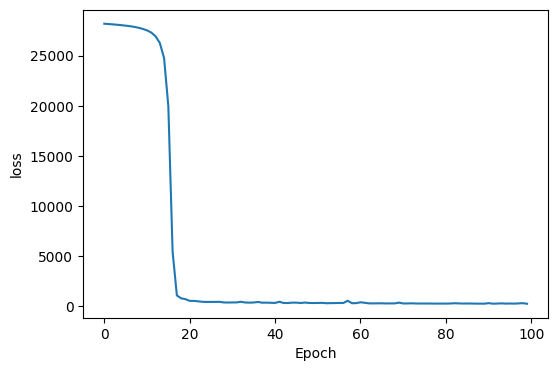

1/1 [==============================] - 0s 10ms/step
Final MSE on test data: 3292.4453473412236
Finished ML_10_trial_op3.py


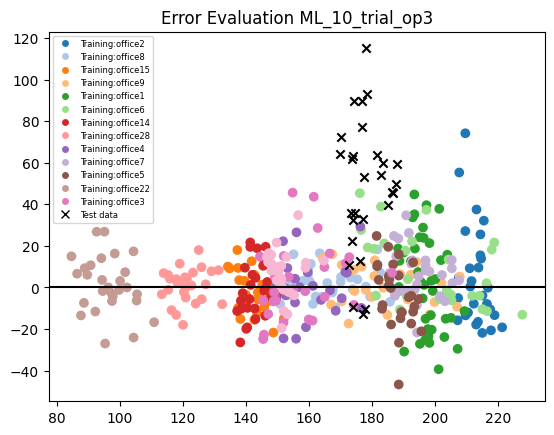

In [12]:
best_batch_size = study.best_trial.params['batch_size']
print(best_batch_size)
# 最適なパラメータを使ってモデルの作成
best_model = create_model(study.best_trial)
train_history = best_model.fit(
                                X_train, y_train, 
                                batch_size=best_batch_size,
                                epochs=100, 
                                verbose=0
                                )

print(train_history.history.keys())

print(train_history.history)
print(len(train_history.history['loss']))

# エポックごとの損失関数値をプロットしてみる
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(train_history.history['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')
plt.show()

# 評価
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_test_pred)
print('Final MSE on test data:', final_mse)
# print(y_test_pred)


# 図を作成するための準備
df_train['predict values'] = y_train_pred
df_train['residuals'] = y_train_pred - y_train
df_test['predict values'] = y_test_pred
df_test['residuals'] = y_test_pred - y_test


#df_trainに'legend'列を追加(凡例)
root_directory = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/"
for folder_name in os.listdir(root_directory):  
        for index,row in df_train.iterrows() :           #１行ずつ実行
                if folder_name + '_' in row['case_name']:                 #case_nameにfolder_nameが含まれているかどうか
                        df_train.loc[index,'legend'] = 'Training:' + folder_name

df_test['legend'] = 'Test data'

df_forfig = pd.concat([df_train, df_test])
# df_forfig.to_csv("/home/gakubu/デスクトップ/ML_git/MLT/ML_9/ML_9_5/df_forfig XGB.csv"\
#                         ,encoding='utf_8_sig', index=False)

#-----Error Evaluation (+test) DTR.pdfの作成-------------------------------------------
# 各オフィス名に対する色を 'tab20' カラーマップから取得
legend_names = df_train['legend'].unique()      #unique()メソッドは指定した列内の一意の値の配列を返す（重複を取り除く）
# print(legend_names)
colors = plt.cm.tab20(range(len(legend_names))) #tab20から配列legemd_namesの長さ分の色の配列colorsを返す
# 凡例名と色の対応を辞書に格納
# zip関数は２つ以上のリストを取り、それらの対応する要素をペアにしてイテレータを返す。
# この場合、legend_namesとcolorsの２つのリストをペアにし、対応する要素同士を取得する。
# =以降はofficeをキーとしてそれに対応するcolorが"値"として格納される辞書を作成
legend_color_mapping = {legend: color for legend, color in zip(legend_names, colors)}
# print(legend_color_mapping)
# 'legend' 列を数値（色情報に対応する数値）に変換
# 'legend_num'　を追加
df_train['legend_num'] = df_train['legend'].map(legend_color_mapping)
#散布図を作成
plt.scatter(df_train['predict values'], df_train['residuals'], c=df_train['legend_num'])
plt.scatter(df_test['predict values'], df_test['residuals'], c='black', marker='x' )
#y=0の直線を引く
# y = 0 の直線を描く
plt.axhline(y=0, color='black', linestyle='-')

# 凡例を作成
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, \
                        markersize=6, label=legend) for legend, color in zip(legend_names, colors)]
# Test dataの凡例を追加
handles[-1] = plt.Line2D([0], [0] ,marker='x', color='black', markersize=6, label='Test data', linestyle='None')

# 凡例を表示
plt.legend(handles=handles, loc='upper left', fontsize=6)


plt.title('Error Evaluation ML_10_trial_op3')
plt.savefig("/home/gakubu/デスクトップ/ML_git/MLT/ML_10/Error Evaluation 10 trial op3.pdf", format='pdf') 
# plt.show()
#-----------------------------------------------------------------------------------

print('Finished ML_10_trial_op3.py')



#各種評価指標をcsvファイルとして出力する
df_ee = pd.DataFrame({
                        'MSE(平均二乗誤差)': [mean_squared_error(y_test, y_test_pred)],
                        'MAE(平均絶対誤差)': [mean_absolute_error(y_test, y_test_pred)]})
df_ee.to_csv("/home/gakubu/デスクトップ/ML_git/MLT/ML_10/Error Evaluation 10 trial op3.csv",encoding='utf_8_sig', index=False)

df_ee_train = pd.DataFrame({
                        'MSE(平均二乗誤差)': [mean_squared_error(y_train, y_train_pred)],
                        'MAE(平均絶対誤差)': [mean_absolute_error(y_train, y_train_pred)]})
df_ee_train.to_csv("/home/gakubu/デスクトップ/ML_git/MLT/ML_10/Error Evaluation 10 trial op3 train.csv",encoding='utf_8_sig', index=False)